## Práctica 3: Reglas de Asociación
#### Gergana Rosenova Tsakova

Resumen:

Primero preparo los datos de tal manera que el TransactionEncoder pueda trabajar con ellos. Usando el encoder obtengo una matriz con las filas representando las transacciones y las columnas - los productos. Calculo el soporte que necesito si consideramos una itemset frecuente, si aparece en más de 32 000 transacciones. Uso la matriz para ejecutar el algritmo apriori que me saca una lista de los itemsets frecuentes. También aplico el algoritmo FP-Max para extraer los itemsets frecuentes máximales.

Uso los itemsets frecuentes y la función association_rules para encotrar las reglas de asociación. Después una a una respondo a las preguntas de la práctica. Ya que el número de transacciones ha aumentado de 3200 a 32000, muchas de las preguntas no tienen respuesta. Sin embargo, yo he implementado el código y para asegurarme de que funcione he probado con otros productos o valores.

Importo las librerías que voy a necesitar.

In [3]:
import pandas as pd
import numpy as np
import pickle

Leo los ficheros de datos y los guardo en DataFrames. El fichero con los peidos contiene 32434489 filas, cada fila está compuesta por identificador del pedido, identificador del productos, el ordén del producto en el carro y si este producto está comprado de nuevo.

In [6]:
pedidos = pd.read_csv("./pedidos_mini.csv")
pedidos

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0
...,...,...,...,...,...
2999995,2999995,316715,14114,1,1
2999996,2999996,316715,41950,2,1
2999997,2999997,316715,43789,3,0
2999998,2999998,316716,6050,1,1


In [8]:
productos = pd.read_csv("./productos.csv", index_col='product_id')

El la base da datos disponemos de 49688 distintos productos.

In [9]:
productos = productos['product_name']
productos

product_id
1                               Chocolate Sandwich Cookies
2                                         All-Seasons Salt
3                     Robust Golden Unsweetened Oolong Tea
4        Smart Ones Classic Favorites Mini Rigatoni Wit...
5                                Green Chile Anytime Sauce
                               ...                        
49684            Vodka, Triple Distilled, Twist of Vanilla
49685                   En Croute Roast Hazelnut Cranberry
49686                                     Artisan Baguette
49687           Smartblend Healthy Metabolism Dry Cat Food
49688                               Fresh Foaming Cleanser
Name: product_name, Length: 49688, dtype: object

Creo un diccionario que voy a usar después para cambiar los ids de los productos por sus nombres al buscar los itemsets y las reglas de asociación.

In [10]:
productos_dict = productos.to_dict()

#### ¿Qué soporte debemos establecer?

Consideramos que un itemset es frecuente cuando aparece en al menos 32 200 transacciones. Para calcular el soporte tenemos que dividir este número entre el número total de transacciones.


In [11]:
print('Soporte para 3200:', 3200 / len(pedidos['order_id'].unique()))
print('Soporte para 32000:', 32000 / len(pedidos['order_id'].unique()))

Soporte para 3200: 0.010758002104534162
Soporte para 32000: 0.10758002104534162


Ya que para usar el TransactionEncoder necesito tener los datos de tal manera que cada pedido está representado por un array con sus productos, agrupo los pedidos y obtengo un nuevo dataframe. Este dataframe guardo en un fichero .csv para poder reutilizarlo.

In [12]:
grouped = pedidos.groupby('order_id')['product_id'].apply(list)
grouped

order_id
2         [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3         [33754, 24838, 17704, 21903, 17668, 46667, 174...
4         [46842, 26434, 39758, 27761, 10054, 21351, 225...
5         [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                     [40462, 15873, 41897]
                                ...                        
316712                                       [47766, 30489]
316714    [4210, 6287, 30776, 41332, 25522, 41213, 2962,...
316715                                [14114, 41950, 43789]
316716                                               [6050]
316717                                              [48206]
Name: product_id, Length: 297453, dtype: object

In [13]:
grouped.to_csv('data/grouped.csv')

Importo el módulo ast para poder usar su función ast.literal_eval. De está manera puedo convertir el valor en el dataframe de los productos de un string a un array. 

In [14]:
import ast

grouped = pd.read_csv('data/grouped.csv', index_col=0)
dataset = grouped['product_id'].apply(ast.literal_eval)

Importo el TransactionEncoder de la librería mlxtend. Hago una instacia del encoder, le entreno y transformo el dataset a una matriz de tipo sparse para que ocupe menos espacio. Convierto la matriz en un dataframe y imprimo el resultado.

Es un dataframe de 3214874 filas, que representan todas las transacciones y 49677 columnas, que son los identificadores de los productos. Si un producto aparece en un pedido el valor es 1, si no, es 0.

In [16]:
%pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 2.4 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.4 MB 7.3 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 10.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset, sparse=True)
df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
#df.columns = [str(i) for i in df.columns] #daba un error
df

C:\Users\acull\AppData\Local\Temp\ipykernel_23372\3540267233.py:5: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  df = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  output = repr(obj)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  output = repr(obj)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_v

,1,2,3,4,5,8,9,10,11,12,...,49677,49678,49679,49680,49681,49682,49683,49685,49686,49688
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Guardo el dataframe en formato pickle para poder reutilizarlo.

In [18]:
with open('data/matriz.pkl', 'wb') as f:
    pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
with open('data/matriz.pkl', 'rb') as f:
    df = pickle.load(f)

Usando el dictionary con los nombres de los productos que he creado anteriormente, cambio los identificadores de la tabla por los nombres de los productos.

In [20]:
#renombrar columnas
df = df.rename(columns = productos_dict)
df

C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  output = repr(obj)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  output = repr(obj)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  output = repr(obj)
C:\Users\acull\AppData\Roaming\Python\Python312\site-packages\IPython\lib\pretty.py:778: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is depr

,Chocolate Sandwich Cookies,All-Seasons Salt,Robust Golden Unsweetened Oolong Tea,Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce,Green Chile Anytime Sauce,Cut Russet Potatoes Steam N' Mash,Light Strawberry Blueberry Yogurt,Sparkling Orange Juice & Prickly Pear Beverage,Peach Mango Juice,Chocolate Fudge Layer Cake,...,Thick & Chunky Sloppy Joe Sauce,Large Chicken & Cheese Taquitos,Famous Chocolate Wafers,All Natural Creamy Caesar Dressing,Spaghetti with Meatballs and Sauce Meal,California Limeade,Cucumber Kirby,En Croute Roast Hazelnut Cranberry,Artisan Baguette,Fresh Foaming Cleanser
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
297451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### ¿Cuántos items frecuentes encontramos?

Para poder encontrar los itemsets frecuentes usamos el alogortmo apriori. Como minímo soporte ponemos el que calculamos al principio. De esta manera obtenemos una lista con los itemsets frecuentes - 118.

In [21]:
from mlxtend.frequent_patterns import apriori
#soporte con 32000 -> 0.0099
frequent_itemsets = apriori(df, min_support=0.0099, use_colnames=True, verbose=1, low_memory=True)
frequent_itemsets

Processing 48 combinations | Sampling itemset size 2


,support,itemsets
0,0.011155,(Soda)
1,0.011635,(100% Raw Coconut Water)
2,0.011494,(Whole Milk)
3,0.022898,(Yellow Onions)
4,0.011467,(Shredded Parmesan)
...,...,...
114,0.010610,"(Banana, Organic Fuji Apple)"
115,0.010028,"(Banana, Organic Hass Avocado)"
116,0.012721,"(Banana, Large Lemon)"
117,0.016413,"(Banana, Organic Avocado)"


Añadimos una columna con el tamaño de los itemsets.

In [22]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.011155,(Soda),1
1,0.011635,(100% Raw Coconut Water),1
2,0.011494,(Whole Milk),1
3,0.022898,(Yellow Onions),1
4,0.011467,(Shredded Parmesan),1
...,...,...,...
114,0.010610,"(Banana, Organic Fuji Apple)",2
115,0.010028,"(Banana, Organic Hass Avocado)",2
116,0.012721,"(Banana, Large Lemon)",2
117,0.016413,"(Banana, Organic Avocado)",2


El número de itemsets de longitud 2 o más es 15.

In [23]:
len(frequent_itemsets[frequent_itemsets['length'] >= 2])

16

También uso el algoritmo FP-Max para extraer los itemsets máximales, que voy a necesitar más tarde en la práctica. Se puede ver que de los 118 itemset que tenemos, 107 son máximales.

In [24]:
from mlxtend.frequent_patterns import fpmax

maximal_itemsets = fpmax(df, min_support=0.0099, use_colnames=True, verbose=0)
maximal_itemsets['length'] = maximal_itemsets['itemsets'].apply(lambda x: len(x))
maximal_itemsets

,support,itemsets,length
0,0.010049,(Feta Cheese Crumbles),1
1,0.010113,(Organic Spring Mix),1
2,0.010119,(Organic Large Brown Grade AA Cage Free Eggs),1
3,0.010247,(Organic Broccoli Florets),1
4,0.010344,(Sparkling Lemon Water),1
...,...,...,...
103,0.011830,"(Organic Baby Spinach, Organic Strawberries)",2
104,0.015542,"(Bag of Organic Bananas, Organic Baby Spinach)",2
105,0.016231,"(Banana, Organic Baby Spinach)",2
106,0.017502,"(Banana, Organic Strawberries)",2


Guardo ambos dataframes.

In [25]:
frequent_itemsets.to_pickle('data/frequent_itemsets.pkl')
maximal_itemsets.to_pickle('data/maximal_itemsets.pkl')

#### ¿Cuál de ellos tiene el soporte más alto?

Ordeno los itemsets frequetes por el soporte. Se puede ver que el itemset (Banana) tiene el mayor soporte - 0.147.

In [26]:
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets,length
42,0.147791,(Banana),1
21,0.117810,(Bag of Organic Bananas),1
31,0.082090,(Organic Strawberries),1
34,0.075326,(Organic Baby Spinach),1
97,0.065970,(Organic Hass Avocado),1
...,...,...,...
59,0.010119,(Organic Large Brown Grade AA Cage Free Eggs),1
73,0.010113,(Organic Spring Mix),1
78,0.010049,(Feta Cheese Crumbles),1
118,0.010049,"(Banana, Cucumber Kirby)",2


#### ¿Cuántos de los itemsets frecuentes contienen el producto “Seedless Red Grapes”?

Un itemset de tamaño 1 contiene el producto 'Seedless Red Grapes'.

In [27]:
producto = 'Seedless Red Grapes' 

grapes = frequent_itemsets[frequent_itemsets.apply(lambda x: producto in x['itemsets'], axis=1) == True] 
grapes

,support,itemsets,length
5,0.026051,(Seedless Red Grapes),1


#### ¿Cuál de ellos, con un tamaño de al menos dos items, tiene el soporte más alto?

Ya que no hay itemsets de tamaño mayor de 1, que contienen el producto no me sale ningún resultado.

In [28]:
grapes[grapes['length']>= 2].sort_values(by='support', ascending=False)

,support,itemsets,length


Sin embargo, pruebo con otro producto para verificar que el código funciona. El itemset con el soporte más alto es el (Bag of Organic Bananas, Organic Strawberries) con soporte 0.019.

In [29]:
producto = 'Organic Strawberries' 

grapes = frequent_itemsets[frequent_itemsets.apply(lambda x: producto in x['itemsets'], axis=1) == True]
grapes[grapes['length']>= 2].sort_values(by='support', ascending=False)

,support,itemsets,length
103,0.019032,"(Bag of Organic Bananas, Organic Strawberries)",2
109,0.017502,"(Banana, Organic Strawberries)",2
111,0.012745,"(Organic Strawberries, Organic Hass Avocado)",2
108,0.011830,"(Organic Baby Spinach, Organic Strawberries)",2
110,0.010281,"(Organic Raspberries, Organic Strawberries)",2


#### ¿Cuántos de los itemset frecuentes están incluidos en otros?

Los itemsets que están incluidos en otros son los itemsets no máximales. De los que hemos hecho hasta el momento sabemos que existen 11 itemsets así. Sin embargo, usando un bucle donde para cada itemset compruebo si forma de otro itemset, saco los itemsets no maximales. En total son 11 y se puede ver en que otros itemsets están incluidos.

Con este algoritmo también se podrían encontrar los itemsets máximales.

In [30]:
#obtengo una lista de los itemsets
itemsets = []
for itemset in frequent_itemsets['itemsets'].to_list():
    itemsets.append(list(itemset))
itemsets

count = 0
#para cada itemset veo si forma parte de otro itemset
for itemset in itemsets:
    temp = frequent_itemsets[(frequent_itemsets.apply(lambda x: itemset[0] in x['itemsets'], axis=1) == True) & (frequent_itemsets['length'] > len(itemset))]
    if not temp.empty:
        count += 1
        print('Product id:', itemset)
        print(temp, '\n')
print('Número de itemset frecuentes incluidos en otros:', count)

Product id: ['Bag of Organic Bananas']
      support                                        itemsets  length
103  0.019032  (Bag of Organic Bananas, Organic Strawberries)       2
104  0.015542  (Bag of Organic Bananas, Organic Baby Spinach)       2
105  0.012291   (Organic Raspberries, Bag of Organic Bananas)       2
106  0.019230  (Bag of Organic Bananas, Organic Hass Avocado)       2 

Product id: ['Strawberries']
      support                itemsets  length
107  0.013118  (Banana, Strawberries)       2 

Product id: ['Organic Strawberries']
      support                                        itemsets  length
103  0.019032  (Bag of Organic Bananas, Organic Strawberries)       2
108  0.011830    (Organic Baby Spinach, Organic Strawberries)       2
109  0.017502                  (Banana, Organic Strawberries)       2
110  0.010281     (Organic Raspberries, Organic Strawberries)       2
111  0.012745    (Organic Strawberries, Organic Hass Avocado)       2 

Product id: ['Organic Baby 

#### Determina el valor necesario de confianza para que se generen 169 reglas con el soporte anteriormente definido.

Con el soporte mínimo que hemos establecido al principio, en teoría no se podrían generar más de 30 reglas, porque tenemos solo 15 itemsets de tamaño 2. Uso una confianza de 0.2 y genero 11 reglas de asociación, cada una con un antecedente y un consequente.

In [31]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Strawberries),(Bag of Organic Bananas),0.082090,0.117810,0.019032,0.231837,1.967887,0.009361,1.148441,0.535827
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.075326,0.117810,0.015542,0.206329,1.751365,0.006668,1.111530,0.463966
2,(Organic Raspberries),(Bag of Organic Bananas),0.042097,0.117810,0.012291,0.291966,2.478275,0.007332,1.245971,0.622708
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.065970,0.117810,0.019230,0.291495,2.474273,0.011458,1.245142,0.637925
4,(Strawberries),(Banana),0.044699,0.147791,0.013118,0.293472,1.985716,0.006512,1.206192,0.519630
5,(Organic Strawberries),(Banana),0.082090,0.147791,0.017502,0.213203,1.442596,0.005370,1.083137,0.334244
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.082090,0.010281,0.244210,2.974898,0.006825,1.214504,0.693029
7,(Organic Baby Spinach),(Banana),0.075326,0.147791,0.016231,0.215478,1.457987,0.005099,1.086277,0.339712
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.010610,0.380746,2.576236,0.006492,1.376185,0.629375
9,(Large Lemon),(Banana),0.047732,0.147791,0.012721,0.266516,1.803328,0.005667,1.161865,0.467799


Visualizar los resultados.

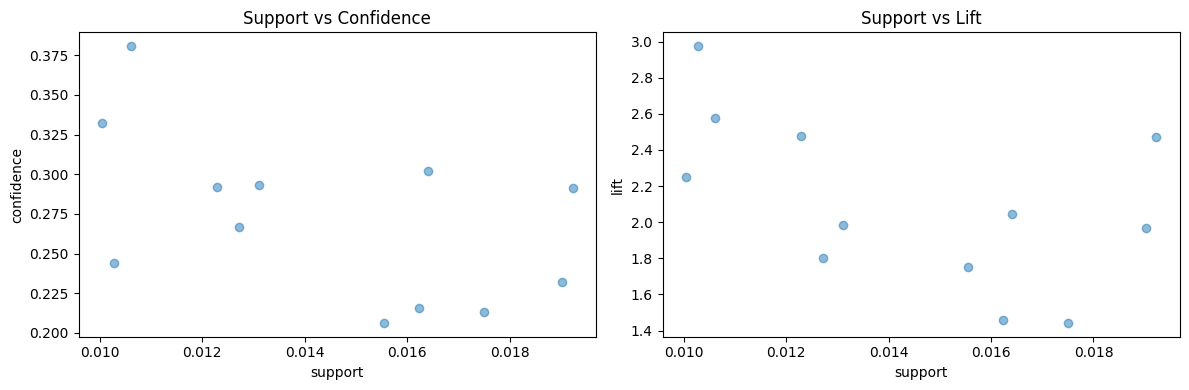

In [32]:
import matplotlib.pyplot as plt

fig, axes=plt.subplots(figsize=(12,4), nrows=1, ncols=2, dpi=100)

axes[0].scatter(rules['support'], rules['confidence'], alpha=0.5)
axes[0].set_title('Support vs Confidence')
axes[0].set_xlabel('support')
axes[0].set_ylabel('confidence')

axes[1].scatter(rules['support'], rules['lift'], alpha=0.5)
axes[1].set_title('Support vs Lift')
axes[1].set_xlabel('support')
axes[1].set_ylabel('lift')

fig.tight_layout()
plt.show()

#### Al conjunto de reglas generadas añádele la medida basada en el ínidce de Jaccard.

Definimos una función que aplicamos a cada fila del dataframe para calcular el ínidce de Jaccard para cada regla. El índice de Jaccard representa la probabilidad de que dos productos estén en la misma transacción, o sea, se compren juntos.

In [33]:
def jaccard_func(row):
    return row['support'] / (row['antecedent support'] + row['consequent support'] - row['support'])

rules['jaccard_similarity'] = rules.apply(lambda x: jaccard_func(x), axis=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity
0,(Organic Strawberries),(Bag of Organic Bananas),0.082090,0.117810,0.019032,0.231837,1.967887,0.009361,1.148441,0.535827,0.105223
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.075326,0.117810,0.015542,0.206329,1.751365,0.006668,1.111530,0.463966,0.087514
2,(Organic Raspberries),(Bag of Organic Bananas),0.042097,0.117810,0.012291,0.291966,2.478275,0.007332,1.245971,0.622708,0.083263
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.065970,0.117810,0.019230,0.291495,2.474273,0.011458,1.245142,0.637925,0.116863
4,(Strawberries),(Banana),0.044699,0.147791,0.013118,0.293472,1.985716,0.006512,1.206192,0.519630,0.073133
5,(Organic Strawberries),(Banana),0.082090,0.147791,0.017502,0.213203,1.442596,0.005370,1.083137,0.334244,0.082409
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.082090,0.010281,0.244210,2.974898,0.006825,1.214504,0.693029,0.090254
7,(Organic Baby Spinach),(Banana),0.075326,0.147791,0.016231,0.215478,1.457987,0.005099,1.086277,0.339712,0.078454
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.010610,0.380746,2.576236,0.006492,1.376185,0.629375,0.064285
9,(Large Lemon),(Banana),0.047732,0.147791,0.012721,0.266516,1.803328,0.005667,1.161865,0.467799,0.069591


#### ¿Cuantas de dichas reglas son máximales? 

Consideramos máximales las reglas que fueron generadas a partir de un itemset máximal. Ya tenemos la lista de los itemsets máximales gracias a la función FP-max. Definimos una función donde primero se reconstruye el itemset de la regla generada y se devuelve si este itemset está en la lista con los itemsets máximales o no. Añado una columna con el resultado.

Todas las reglas que tenemos son máximales.

In [34]:
from functools import reduce

def maximal(row):
    #reconstruir los itemsets a partir de las reglas generadas
    rule_itemset = reduce(frozenset.union, [row.antecedents, row.consequents])
    #comprobar si el itemset está en el df con los itemsets maximales
    return rule_itemset in set(maximal_itemsets['itemsets']) #return true or false

#anadir una nueva columna indicando si la regla es maximal o no
rules['maximal'] = rules.apply(lambda x: maximal(x), axis=1)
rules[rules['maximal'] == True]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal
0,(Organic Strawberries),(Bag of Organic Bananas),0.082090,0.117810,0.019032,0.231837,1.967887,0.009361,1.148441,0.535827,0.105223,True
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.075326,0.117810,0.015542,0.206329,1.751365,0.006668,1.111530,0.463966,0.087514,True
2,(Organic Raspberries),(Bag of Organic Bananas),0.042097,0.117810,0.012291,0.291966,2.478275,0.007332,1.245971,0.622708,0.083263,True
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.065970,0.117810,0.019230,0.291495,2.474273,0.011458,1.245142,0.637925,0.116863,True
4,(Strawberries),(Banana),0.044699,0.147791,0.013118,0.293472,1.985716,0.006512,1.206192,0.519630,0.073133,True
5,(Organic Strawberries),(Banana),0.082090,0.147791,0.017502,0.213203,1.442596,0.005370,1.083137,0.334244,0.082409,True
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.082090,0.010281,0.244210,2.974898,0.006825,1.214504,0.693029,0.090254,True
7,(Organic Baby Spinach),(Banana),0.075326,0.147791,0.016231,0.215478,1.457987,0.005099,1.086277,0.339712,0.078454,True
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.010610,0.380746,2.576236,0.006492,1.376185,0.629375,0.064285,True
9,(Large Lemon),(Banana),0.047732,0.147791,0.012721,0.266516,1.803328,0.005667,1.161865,0.467799,0.069591,True


#### Inidica la regla máximal con la confianza mas alta.

Para indicar la regla con la confianza más alta filtro por la última columna que he creado ('maximal') y ordeno por la columna 'confidence'. Muestro solo la primera fila. La regla máximal con la confianza más alta es (Organic Fuji Apple)->(Banana) con cofianza 0.378693. Esto nos dice lo frecuente que es que Banana aparezca en una transacción que contiene Organic Fuji Apple.

In [35]:
rules[rules['maximal'] == True].sort_values(by='confidence', ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.01061,0.380746,2.576236,0.006492,1.376185,0.629375,0.064285,True


#### ¿Cuántas de dichas reglas están incluidas en otras? 

Consideramos una regla incluida en otra, si los antecedentes de una regla están en los antecedentes de otra y también si los consequentes de una están en los consequentes de otra. Para comprobar esto definimos una función. Dentro de la función, mediante un bucle recorremos todas las reglas y comprbamos si sus antecendentes y consequentes forman parte de los antecendetes y consequetes de otras reglas. El resultado devolvemos en una columna 'included' al final del dataframe.

In [36]:
#anadir una nueva columna indicando si la regla está incluida en otra o no

def included(x):
    count = 0
    #iterar sobre el dataframe con las reglas
    for index, row in rules.iterrows():
        #si los antecedents de una están en antecedents de otra y también si los consequents están en los consequents de otra
        if x.antecedents.issubset(row.antecedents) & x.consequents.issubset(row.consequents):
            #aumento el contador
            count +=1
    #siempre habrá un caso donde esto se cumple porque estaoy comprando con la misma fila
    #por esta razón tengo que considerar casos donde el contador es mayor que 1
    return count > 1

rules['included'] = rules.apply(lambda x: included(x), axis=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included
0,(Organic Strawberries),(Bag of Organic Bananas),0.082090,0.117810,0.019032,0.231837,1.967887,0.009361,1.148441,0.535827,0.105223,True,False
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.075326,0.117810,0.015542,0.206329,1.751365,0.006668,1.111530,0.463966,0.087514,True,False
2,(Organic Raspberries),(Bag of Organic Bananas),0.042097,0.117810,0.012291,0.291966,2.478275,0.007332,1.245971,0.622708,0.083263,True,False
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.065970,0.117810,0.019230,0.291495,2.474273,0.011458,1.245142,0.637925,0.116863,True,False
4,(Strawberries),(Banana),0.044699,0.147791,0.013118,0.293472,1.985716,0.006512,1.206192,0.519630,0.073133,True,False
5,(Organic Strawberries),(Banana),0.082090,0.147791,0.017502,0.213203,1.442596,0.005370,1.083137,0.334244,0.082409,True,False
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.082090,0.010281,0.244210,2.974898,0.006825,1.214504,0.693029,0.090254,True,False
7,(Organic Baby Spinach),(Banana),0.075326,0.147791,0.016231,0.215478,1.457987,0.005099,1.086277,0.339712,0.078454,True,False
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.010610,0.380746,2.576236,0.006492,1.376185,0.629375,0.064285,True,False
9,(Large Lemon),(Banana),0.047732,0.147791,0.012721,0.266516,1.803328,0.005667,1.161865,0.467799,0.069591,True,False


Ninguna de las reglas está incluida en otras reglas.

In [37]:
rules[rules['included'] == True]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included


#### Indica la que tiene el índice de Jaccard más alto.

Para indicar cúal tiene el índice de Jaccard más alto tengo que ordenar por la columna 'jaccard_similarity' que he creado. No me sale ningún resultado, ya que no tengo reglas incluidas.

In [38]:
rules[rules['included'] == True].sort_values(by=['jaccard_similarity'], ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included


Para verificar que el código funciona, hago esto con las reglas no incluidas.

In [39]:
rules[rules['included'] == False].sort_values(by=['jaccard_similarity'], ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included
3,(Organic Hass Avocado),(Bag of Organic Bananas),0.06597,0.11781,0.01923,0.291495,2.474273,0.011458,1.245142,0.637925,0.116863,True,False


#### ¿Cuántas reglas no maximales existen?

Para ver el nímero de reglas no máximales filtro por la columna 'máximal' que he creado. No tenfo reglas no maximales.

In [40]:
rules[rules['maximal'] == False]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included


#### Indica la que tenga la confianza más alta y tenga, al menos, 2 items en el antecedente.

No hay regla no máximal que tiene confianza más alta y tiene al menos 2 items en el antecedente porque no tengo reglas no máximales y no tengo reglas con más de 1 item en el antecedente.

In [41]:
temp = rules[rules['maximal'] == False]
temp['ant_len']= temp['antecedents'].str.len()
temp[temp['ant_len'] >= 2].sort_values(by='confidence', ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included,ant_len


Sin embargo, pruebo el código con las reglas máximaes y con 1 item en el antecedente para obtener algún resultado.

In [42]:
#para ver si funciona pruebo con los maximales y pongo el len a 1
temp = rules[rules['maximal'] == True]
temp['ant_len']= temp['antecedents'].str.len()
temp[temp['ant_len'] >= 1].sort_values(by='confidence', ascending = False).head(1)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included,ant_len
8,(Organic Fuji Apple),(Banana),0.027867,0.147791,0.01061,0.380746,2.576236,0.006492,1.376185,0.629375,0.064285,True,False,1


#### Indica el número de transacciones en las que se verifica la regla con la confianza más alta y que, además, incluyan “Organic Strawberries” en el antecedente o el consecuente

Primero encuentro la regla con mayor confianza que incluye el producto 'Organic Strawberries'. 

In [43]:
#encuentro las reglas que contienen 'Organic Strawberries'
product_name = 'Organic Strawberries'

def find_product(x):
    return product_name in x.antecedents or product_name in x.consequents

rules['product'] = rules.apply(lambda x: find_product(x), axis=1)
rules[rules['product'] == True] 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included,product
0,(Organic Strawberries),(Bag of Organic Bananas),0.082090,0.117810,0.019032,0.231837,1.967887,0.009361,1.148441,0.535827,0.105223,True,False,True
5,(Organic Strawberries),(Banana),0.082090,0.147791,0.017502,0.213203,1.442596,0.005370,1.083137,0.334244,0.082409,True,False,True
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.082090,0.010281,0.244210,2.974898,0.006825,1.214504,0.693029,0.090254,True,False,True


Ya que no tengo reglas no máximales hago uso de las máximales para completar la tarea.

In [44]:
#ya que no tengo reglas no maximales, uso la lista con las maximales 
regla = rules[rules['product'] == True].sort_values(by=['confidence'], ascending = False).head(1)
regla

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,jaccard_similarity,maximal,included,product
6,(Organic Raspberries),(Organic Strawberries),0.042097,0.08209,0.010281,0.24421,2.974898,0.006825,1.214504,0.693029,0.090254,True,False,True


Reconstruyo el itemset de la regla.

In [45]:
rule_itemset = reduce(frozenset.union, [regla.iloc[0].antecedents, regla.iloc[0].consequents])
rule_itemset

frozenset({'Organic Raspberries', 'Organic Strawberries'})

Ya que tengo las transacciones en un dataframes con los identificadores y no con los nombres, la primera cosa que hago es buscar los identificadores de los productos.

In [46]:
print(productos[productos == "Organic Raspberries"])
print(productos[productos == "Organic Strawberries"])

product_id
27966    Organic Raspberries
Name: product_name, dtype: object
product_id
21137    Organic Strawberries
Name: product_name, dtype: object


Creo un itemset con los identificadores de los productos y en el dataframe con los pedidos busco si el itemset está en en la transacción. 56156 pedidos verifican la regla.

In [47]:
pedidos = grouped.copy()

rule_itemset = {27966, 21137}

pedidos['product_id'] = pedidos['product_id'].apply(ast.literal_eval)

def includes_rule(x):
    return rule_itemset.issubset(set(x.product_id))

pedidos['includes'] = pedidos.apply(lambda x: includes_rule(x), axis=1)
pedidos[pedidos['includes'] == True]

,product_id,includes
order_id,,
254,"[44275, 27966, 27695, 45840, 4957, 5077, 13176...",True
493,"[1940, 24852, 24024, 21137, 27966, 19173, 2660...",True
655,"[20876, 10768, 34824, 43050, 46667, 26209, 458...",True
724,"[29941, 18873, 48988, 27966, 21137, 47209]",True
734,"[27966, 43961, 21903, 21405, 44359, 781, 38159...",True
...,...,...
316126,"[39180, 27845, 43961, 47209, 6046, 28204, 2575...",True
316218,"[46616, 18465, 21137, 12701, 19478, 38274, 163...",True
316260,"[27966, 21137, 4455, 27845, 10385, 35140, 2282...",True
